### Sections

- [Linear regression via the least squares method](#Linear-regression-via-the-least-squares-method)  
 
- [Least squares fit implementations](#Least-squares-fit-implementations)
    
    - [Implementation in (C)Python](#Implementation-in-Python)
    
    - [Implementation in Cython](#Implementation-in-Cython)
    
    - [Implementation in Fortran](#Implementation-in-Fortran)

- [Generating sample data and benchmarking](#Generating-sample-data-and-benchmarking)

    - [Verification that all implementations yield similar results](#Verification-that-all-implementations-yield-similar-results)
    
    - [Visualization](#Visualization)
    
    - [Benchmarking via timeit](#Benchmarking-via-timeit)
    
- ###[Results](#Results)

- [Conclusion](#Conclusion)

<a name="introduction"></a>
<br>
<br>

![Performance vs. Productivity for different programming languages](https://raw.githubusercontent.com/rasbt/One-Python-benchmark-per-day/master/images/cython_vs_chart.png)  
(Note that this chart just reflects my rather objective thoughts after experimenting with Cython, and it is not based on real numbers or benchmarks.)
<br>
<br>
<br>
<br>

## Linear regression via the least squares method

For this benchmark, we will implement a naive least squares method for linear regression, which is the simplest approach to performing a regression analysis of a dependent and a explanatory variable. 

The objective is to find the best-fitting straight line through a set of points that minimizes the sum of the squared offsets from the line.  
The offsets come in 2 different flavors: perpendicular and vertical - with respect to the line.  
![](https://raw.githubusercontent.com/rasbt/One-Python-benchmark-per-day/master/images/least_squares_vertical.png)  
![](https://raw.githubusercontent.com/rasbt/One-Python-benchmark-per-day/master/images/least_squares_perpendicular.png)  

As Michael Burger summarizes it nicely in his article "[Problems of Linear Least Square Regression - And Approaches to Handle Them](http://www.arsa-conf.com/archive/?vid=1&aid=2&kid=60101-220)": "the perpendicular offset method delivers a more precise result but is are more complicated to handle. Therefore normally the vertical offsets are used."  
Here, we will also use the method of computing the vertical offsets.



In more mathematical terms, our goal is to compute the best fit to *n* points $(x_i, y_i)$ with $i=1,2,...n,$ via linear equation of the form  
$f(x) = a\cdot x + b$.  
We further have to assume that the y-component is  functionally dependent on the x-component.  
In a cartesian coordinate system, $b$ is the intercept of the straight line with the y-axis, and $a$ is the slope of this line.

$a = \frac{S_{x,y}}{\sigma_{x}^{2}}\quad$  (slope)


$b = \bar{y} - a\bar{x}\quad$ (y-axis intercept)

where 


$S_{xy} = \sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})\quad$ (covariance)


$\sigma{_x}^{2} = \sum_{i=1}^{n} (x_i - \bar{x})^2\quad$ (variance)

<a name="implementations"></a>
<br>
<br>

## Least squares fit implementations

<a name="implementations"></a>
<br>
<br>

After I experimented with different libraries, the numpy functions, and other tweaks, I decided to go back and implement the least squares fit method in (C)Python without any external libraries - using just the pure standard lib. Python.

For Cython and Fortran, we will be using NumPy `arrays` for more efficient memory access.

<a id='Implementation-in-Python'</a>

### Implementation in (C)Python

[[back to top]](#Sections)

In [1]:
def python_lstsqr(x_list, y_list):
    """ Computes the least-squares solution to a linear matrix equation. """
    N = len(x_list)
    x_avg = sum(x_list)/N
    y_avg = sum(y_list)/N
    var_x, cov_xy = 0, 0
    for x,y in zip(x_list, y_list):
        temp = x - x_avg
        var_x += temp**2
        cov_xy += temp * (y - y_avg)
    slope = cov_xy / var_x
    y_interc = y_avg - slope*x_avg
    return (slope, y_interc)

<a name="implementations"></a>
<br>
<br>

### Implementation in Cython

[[back to top]](#Sections)

Cython (see [Cython's C-extensions for Python](http://cython.org)) is basically a hybrid between C and Python and can be pictured as compiled Python code with type declarations.  
Since we are working in an IPython notebook here, we can make use of the very convenient *IPython magic*: It will take care of the conversion to C code, the compilation, and eventually the loading of the function.  
Also, we are adding C type declarations; those type declarations are not necessary for using Cython, however, it will improve the performance of our code significantly.

In [2]:
%load_ext cythonmagic

In [3]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
@cython.boundscheck(False) 
@cython.wraparound(False)
@cython.cdivision(True)
cpdef cython_lstsqr(x_ary, y_ary):
    """ Computes the least-squares solution to a linear matrix equation. """
    cdef double x_avg, y_avg, var_x, cov_xy,\
         slope, y_interc, temp
    cdef double[:] x = x_ary # memoryview
    cdef double[:] y = y_ary
    cdef unsigned long N, i
    
    N = x.shape[0]
    x_avg = 0
    y_avg = 0
    for i in range(N):
        x_avg += x[i]
        y_avg += y[i]
    x_avg = x_avg/N
    y_avg = y_avg/N
    var_x = 0
    cov_xy = 0
    for i in range(N):
        temp = (x[i] - x_avg)
        var_x += temp**2
        cov_xy += temp*(y[i] - y_avg)
    slope = cov_xy / var_x
    y_interc = y_avg - slope*x_avg
    return (slope, y_interc)

Thanks to Joshua Adelman and Andreas Mayer for pointing out some flaws in the initial version of the Cython implementation.

Upon request I added the untyped version (identical to the (C)Python implementation) for comparison below:

In [4]:
%%cython
cimport cython
cpdef cython_lstsqr_untyped(x_list, y_list):
    """ Computes the least-squares solution to a linear matrix equation. """
    N = len(x_list)
    x_avg = sum(x_list)/N
    y_avg = sum(y_list)/N
    var_x, cov_xy = 0, 0
    for x,y in zip(x_list, y_list):
        temp = x - x_avg
        var_x += temp**2
        cov_xy += temp * (y - y_avg)
    slope = cov_xy / var_x
    y_interc = y_avg - slope*x_avg
    return (slope, y_interc)

<a name="implementations"></a>
<br>
<br>

### Implementation in Fortran

[[back to top]](#Sections)

There is also a convenient IPython magic command for compiling Fortran code. The Fortran magic uses NumPy's [`F2PY`](http://wiki.scipy.org/F2py) module for compiling and running the Fortran code. For more information, please see the ['Fortran magic's documentation'](http://nbviewer.ipython.org/github/mgaitan/fortran_magic/blob/master/documentation.ipynb).


In [1]:
%install_ext https://raw.github.com/mgaitan/fortran_magic/master/fortranmagic.py

Installed fortranmagic.py. To use it, type:
  %load_ext fortranmagic


In [5]:
%load_ext fortranmagic

In [6]:
%%fortran
SUBROUTINE fortran_lstsqr(ary_x, ary_y, slope, y_interc)
    ! Computes the least-squares solution to a linear matrix equation. """
    IMPLICIT NONE
    REAL(8), INTENT(in), DIMENSION(:) :: ary_x, ary_y
    REAL(8), INTENT(out) :: slope, y_interc
    REAL(8) :: x_avg, y_avg, var_x, cov_xy, temp
    INTEGER(8) :: N, i
    
    N = SIZE(ary_x)

    x_avg = SUM(ary_x) / N
    y_avg = SUM(ary_y) / N
    var_x = 0
    cov_xy = 0
    
    DO i = 1, N
        temp = ary_x(i) - x_avg
        var_x = var_x + temp**2
        cov_xy = cov_xy + (temp*(ary_y(i) - y_avg))
    END DO
    
    slope = cov_xy / var_x
    y_interc = y_avg - slope*x_avg

END SUBROUTINE fortran_lstsqr

	Building module "_fortran_magic_a044885f2b0c0feac78a230b6b714e2b"...
		Constructing wrapper function "fortran_lstsqr"...
		  slope,y_interc = fortran_lstsqr(ary_x,ary_y)
	Wrote C/API module "_fortran_magic_a044885f2b0c0feac78a230b6b714e2b" to file "/var/folders/5k/0pmyxbls5tg39vdv6vl3pnvh0000gn/T/tmp5i8i3zxx/src.macosx-10.5-x86_64-3.4/_fortran_magic_a044885f2b0c0feac78a230b6b714e2bmodule.c"
	Fortran 77 wrappers are saved to "/var/folders/5k/0pmyxbls5tg39vdv6vl3pnvh0000gn/T/tmp5i8i3zxx/src.macosx-10.5-x86_64-3.4/_fortran_magic_a044885f2b0c0feac78a230b6b714e2b-f2pywrappers.f"


<a name='numpy_func'></a>
<br>
<br>

<a name='sample_data'></a>
<br>
<br>

## Generating sample data and benchmarking

<br>
<br>

### Verification that all implementations yield same results

[[back to top]](#Sections)

In [7]:
import random
import numpy as np

random.seed(12345)

x = [x_i*random.randrange(8,12)/10 for x_i in range(500)]
y = [y_i*random.randrange(8,12)/10 for y_i in range(100,600)]
x_ary = np.asarray(x)
y_ary = np.asarray(y)

reference = python_lstsqr(x_ary, y_ary)
funcs = [python_lstsqr, cython_lstsqr, 
         cython_lstsqr_untyped,fortran_lstsqr]

for f in funcs:
    assert(reference == f(x_ary, y_ary))    
print('ok')

ok


<br>
<br>


## Visualization

[[back to top]](#Sections)

Just for a visual cheeck for how our dataset is distributed, and how the least squares regression line looks like, we will plot the results in a scatter plot below.

Note that we are only using our "matrix approach" to visualize the results - for simplicity. We expect all 3 approaches to produce similar results, which we confirmed in via the `np.testing.assert_array_almost_equal` function above.

In [8]:
%matplotlib inline

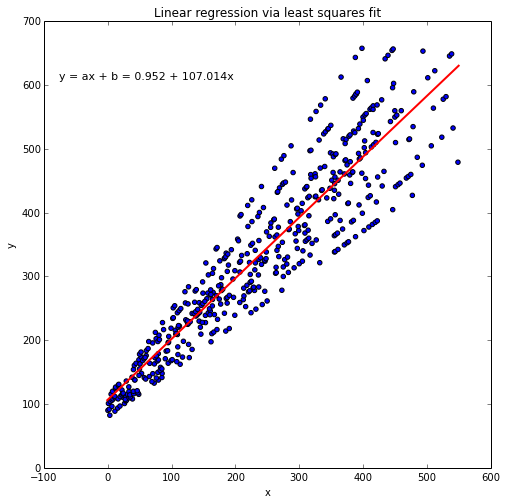

In [9]:
from matplotlib import pyplot as plt
import random

random.seed(12345)

x = [x_i*random.randrange(8,12)/10 for x_i in range(500)]
y = [y_i*random.randrange(8,12)/10 for y_i in range(100,600)]

slope, intercept = python_lstsqr(x, y)

line_x = [round(min(x)) - 1, round(max(x)) + 1]
line_y = [slope*x_i + intercept for x_i in line_x]

plt.figure(figsize=(8,8))
plt.scatter(x,y)
plt.plot(line_x, line_y, color='red', lw='2')

plt.ylabel('y')
plt.xlabel('x')
plt.title('Linear regression via least squares fit')

ftext = 'y = ax + b = {:.3f} + {:.3f}x'\
        .format(slope, intercept)
plt.figtext(.15,.8, ftext, fontsize=11, ha='left')

plt.show()

<br>
<br>

# Benchmarking via timeit

[[back to top]](#Sections)

Now, finally let us take a look at the effect of different sample sizes on the relative performances for each approach.

In [11]:
import timeit
import random
random.seed(12345)

orders_n = [10**n for n in range(1, 6)]
timings = {f.__name__:[] for f in funcs}

for n in orders_n:
    x = ([x_i*np.random.randint(8,12)/10 for x_i in range(n)])
    y = ([y_i*np.random.randint(10,14)/10 for y_i in range(n)])
    x_ary = np.asarray(x)
    y_ary = np.asarray(y)
    x_fary = np.asfortranarray(x)
    y_fary = np.asfortranarray(y)
    timings['python_lstsqr'].append(min(timeit.Timer('python_lstsqr(x, y)', 
            'from __main__ import python_lstsqr, x, y')\
                                        .repeat(repeat=3, number=1000)))
    timings['cython_lstsqr'].append(min(timeit.Timer('cython_lstsqr(x_ary, y_ary)', 
            'from __main__ import cython_lstsqr, x_ary, y_ary')\
                                        .repeat(repeat=3, number=1000)))
    timings['cython_lstsqr_untyped'].append(min(timeit.Timer('cython_lstsqr_untyped(x, y)', 
            'from __main__ import cython_lstsqr_untyped, x, y')\
                                                .repeat(repeat=3, number=1000)))
    timings['fortran_lstsqr'].append(min(timeit.Timer('fortran_lstsqr(x_fary, y_fary)', 
            'from __main__ import fortran_lstsqr, x_fary, y_fary')\
                                         .repeat(repeat=3, number=1000)))

<a name='performance1'></a>
<br>
<br>

## Preparing to plot the results

[[back to top]](#Sections)

In [12]:
import platform
import multiprocessing
from cython import __version__ as cython__version__

def print_sysinfo():
    
    print('\nPython version  :', platform.python_version())
    print('compiler        :', platform.python_compiler())
    print('Cython version  :', cython__version__)
    print('NumPy version   :', np.__version__)
    
    print('\nsystem     :', platform.system())
    print('release    :', platform.release())
    print('machine    :', platform.machine())
    print('processor  :', platform.processor())
    print('CPU count  :', multiprocessing.cpu_count())
    print('interpreter:', platform.architecture()[0])
    print('\n\n')

In [22]:
import matplotlib.pyplot as plt

def plot(timings, title, labels, orders_n):
    plt.rcParams.update({'font.size': 12})

    fig = plt.figure(figsize=(11,10))
    for lb in labels:
        plt.plot(orders_n, timings[lb], alpha=0.5, label=labels[lb], 
                 marker='o', lw=3)
    plt.xlabel('sample size n')
    plt.ylabel('time per computation in milliseconds')
    plt.xlim([min(orders_n) / 10, max(orders_n)* 10])
    plt.legend(loc=2)
    plt.grid()
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title)
    plt.show()

In [32]:
import prettytable

labels = {'python_lstsqr':'Python (Standard Library func.)', 
          'cython_lstsqr':'Cython (NumPy arrays)',  
          'cython_lstsqr_untyped':'Cython untyped (equiv. to Python impl.)', 
          'fortran_lstsqr': 'Fortran (NumPy arrays)',
          }

def summary_table(funcs):
    fit_table = prettytable.PrettyTable(['n=%s' %orders_n[-1], 
                                         'Implementation' ,
                                         'time in msec'])
    fit_table.align['Implementation'] = 'l'
    for l in ['python_lstsqr', 'cython_lstsqr_untyped', 
              'cython_lstsqr', 'fortran_lstsqr']:
        fit_table.add_row(['', labels[l], '{:.3f}'.format(timings[l][-1])])
    print(fit_table)

<a name='performance1'></a>
<br>
<br>

<a name='performance1'></a>
<br>
<br>

# Results

[[back to top]](#Sections)


Python version  : 3.4.1
compiler        : GCC 4.2.1 (Apple Inc. build 5577)
Cython version  : 0.20.1
NumPy version   : 1.8.1

system     : Darwin
release    : 13.2.0
machine    : x86_64
processor  : i386
CPU count  : 2
interpreter: 64bit





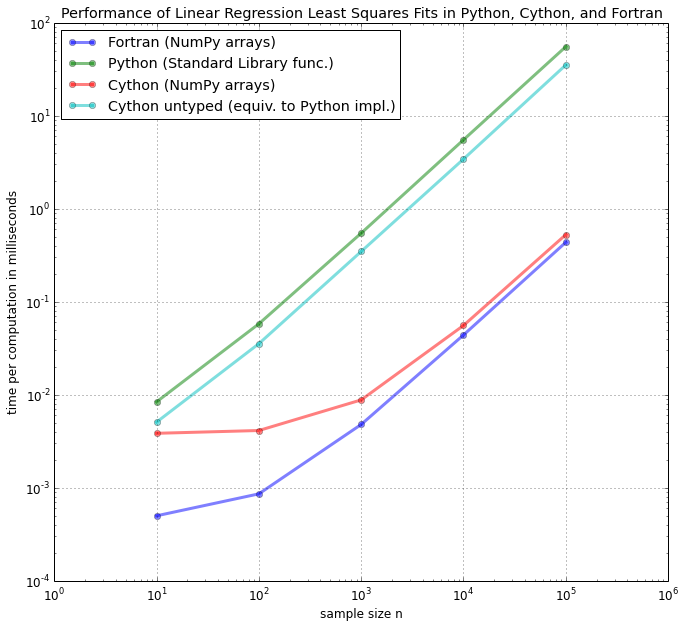

+----------+-----------------------------------------+--------------+
| n=100000 | Implementation                          | time in msec |
+----------+-----------------------------------------+--------------+
|          | Python (Standard Library func.)         |    55.369    |
|          | Cython untyped (equiv. to Python impl.) |    35.196    |
|          | Cython (NumPy arrays)                   |    0.527     |
|          | Fortran (NumPy arrays)                  |    0.436     |
+----------+-----------------------------------------+--------------+


In [33]:
title = 'Performance of Linear Regression Least Squares Fits in Python, Cython, and Fortran'

print_sysinfo()
plot(timings, title, labels, orders_n)
summary_table(funcs)

<a name='performance1'></a>
<br>
<br>

## Conclusion

Of course it is not fair to compare the interpreted Python language to compiled C and Fortran code that have static types at compile time.  
Here, I was mostly interested to see how the code compiled code via Cython stacks against Fortran via F2PY (of course different compiler version can also cause significant differences). And one can say that both are about equal in terms of performance (at least for this simple benchmark).  

It is nice to see that Cython and Fortran code can be used quite conveniently in IPython notebooks, which make them a even more valuable tool for data analyses and algorithm development: Code can be prototyped in Python, and step by step rewritten in context of the original documentation.  
In the case of Cython, it is especially nice that Python and C functions can be mixed and matched to get the best out of both: Productivity and code efficiency.


# References
- https://nbviewer.org/github/rasbt/One-Python-benchmark-per-day/blob/master/ipython_nbs/day10_fortran_lstsqr.ipynb

<a name="cython_bonus"></a>
<br>
<br>

<a name="numba"></a>
<br>
<br>